In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import os

# Data

In [6]:
# Define paths
base_path = os.path.join(os.getcwd(), "Dataset", "Image_Classification")
os.makedirs(base_path, exist_ok=True)

def download_cifar10():
    """Download the full CIFAR-10 dataset"""
    print("Checking/Downloading CIFAR-10 dataset...")
    try:
        # Try to download training set
        train_dataset = datasets.CIFAR10(
            root=base_path,
            train=True,
            download=True if DOWNLOAD_DATASET else False,
            transform=transform
        )
        
        # Try to download test set
        test_dataset = datasets.CIFAR10(
            root=base_path,
            train=False,
            download=True if DOWNLOAD_DATASET else False,
            transform=transform
        )
        
        print("Dataset loading successful.")
        print(f"Dataset is ready at: {base_path}")
        print(f"Full training samples: {len(train_dataset)}")
        print(f"Full test samples: {len(test_dataset)}")
        
        return train_dataset, test_dataset
        
    except Exception as e:
        print(f"Error downloading dataset: {str(e)}")
        return None, None

def create_dataset_split(full_train_dataset, full_test_dataset, sample_ratio=0.1):
    """Create a reduced dataset split"""
    if sample_ratio < 1.0:
        # Calculate sizes for the reduced datasets
        train_size = int(len(full_train_dataset) * sample_ratio)
        test_size = int(len(full_test_dataset) * sample_ratio)
        
        # Create random splits
        train_dataset, _ = torch.utils.data.random_split(
            full_train_dataset, 
            [train_size, len(full_train_dataset) - train_size],
            generator=torch.Generator().manual_seed(42)
        )
        test_dataset, _ = torch.utils.data.random_split(
            full_test_dataset,
            [test_size, len(full_test_dataset) - test_size],
            generator=torch.Generator().manual_seed(42)
        )
    else:
        train_dataset = full_train_dataset
        test_dataset = full_test_dataset
    
    print(f"\nUsing {sample_ratio*100:.1f}% of the dataset:")
    print(f"Training samples: {len(train_dataset)}")
    print(f"Test samples: {len(test_dataset)}")
    
    return train_dataset, test_dataset

# Define image transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # ViT typically uses 224x224 images
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Set to True to download dataset
DOWNLOAD_DATASET = False

# Set to 0.1 for 10% of the dataset, 1.0 for full dataset
DATASET_RATIO = 0.05

# First, download the full dataset
full_train_dataset, full_test_dataset = download_cifar10()

if full_train_dataset is not None and full_test_dataset is not None:
    # Then create the reduced split
    train_dataset, test_dataset = create_dataset_split(
        full_train_dataset, 
        full_test_dataset, 
        sample_ratio=DATASET_RATIO
    )
    
    # Create data loaders
    batch_size = 64
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)
    
    # Print dataset information
    print("\nDataLoader information:")
    print(f"Number of training batches: {len(train_loader)}")
    print(f"Number of test batches: {len(test_loader)}")
    print(f"Input image shape: {next(iter(train_loader))[0].shape}")
else:
    print("Failed to load dataset. Please check your internet connection and try again.")

# CIFAR-10 classes
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Checking/Downloading CIFAR-10 dataset...
Dataset loading successful.
Dataset is ready at: e:\Documents\GitHub\GenAIExample\Dataset\Image_Classification
Full training samples: 50000
Full test samples: 10000

Using 5.0% of the dataset:
Training samples: 2500
Test samples: 500

DataLoader information:
Number of training batches: 40
Number of test batches: 8
Input image shape: torch.Size([64, 3, 224, 224])


# Model

In [7]:
# Vision Transformer Components
class PatchEmbedding(nn.Module):
    def __init__(self, image_size=224, patch_size=16, in_channels=3, embed_dim=768):
        super().__init__()
        self.image_size = image_size
        self.patch_size = patch_size
        self.num_patches = (image_size // patch_size) ** 2
        
        self.projection = nn.Conv2d(in_channels, embed_dim, kernel_size=patch_size, stride=patch_size)
        self.cls_token = nn.Parameter(torch.randn(1, 1, embed_dim))
        self.position_embedding = nn.Parameter(torch.randn(1, self.num_patches + 1, embed_dim))
        
    def forward(self, x):
        # x shape: (batch_size, channels, height, width)
        batch_size = x.shape[0]
        
        # Project patches: (batch_size, embed_dim, grid_size, grid_size)
        x = self.projection(x)
        
        # Flatten patches: (batch_size, num_patches, embed_dim)
        x = x.flatten(2).transpose(1, 2)
        
        # Add cls token
        cls_tokens = self.cls_token.expand(batch_size, -1, -1)
        x = torch.cat([cls_tokens, x], dim=1)
        
        # Add position embedding
        x = x + self.position_embedding
        
        return x

class MultiHeadAttention(nn.Module):
    def __init__(self, embed_dim, num_heads):
        super().__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads
        assert self.head_dim * num_heads == embed_dim, "embed_dim must be divisible by num_heads"
        
        self.qkv = nn.Linear(embed_dim, embed_dim * 3)
        self.proj = nn.Linear(embed_dim, embed_dim)
        
    def forward(self, x):
        batch_size, num_patches, embed_dim = x.shape
        
        # Calculate query, key, value matrices
        qkv = self.qkv(x).reshape(batch_size, num_patches, 3, self.num_heads, self.head_dim)
        qkv = qkv.permute(2, 0, 3, 1, 4)  # (3, batch_size, num_heads, num_patches, head_dim)
        q, k, v = qkv[0], qkv[1], qkv[2]
        
        # Calculate attention scores
        attn = (q @ k.transpose(-2, -1)) * (self.head_dim ** -0.5)
        attn = attn.softmax(dim=-1)
        
        # Apply attention to values
        x = (attn @ v).transpose(1, 2).reshape(batch_size, num_patches, embed_dim)
        x = self.proj(x)
        
        return x

class MLP(nn.Module):
    def __init__(self, embed_dim, mlp_dim):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(embed_dim, mlp_dim),
            nn.GELU(),
            nn.Linear(mlp_dim, embed_dim)
        )
    
    def forward(self, x):
        return self.layers(x)

class TransformerBlock(nn.Module):
    def __init__(self, embed_dim, num_heads, mlp_dim, dropout=0.1):
        super().__init__()
        self.norm1 = nn.LayerNorm(embed_dim)
        self.attn = MultiHeadAttention(embed_dim, num_heads)
        self.norm2 = nn.LayerNorm(embed_dim)
        self.mlp = MLP(embed_dim, mlp_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        x = x + self.dropout(self.attn(self.norm1(x)))
        x = x + self.dropout(self.mlp(self.norm2(x)))
        return x

class VisionTransformer(nn.Module):
    def __init__(self, image_size=224, patch_size=16, in_channels=3, num_classes=10,
                 embed_dim=768, depth=12, num_heads=12, mlp_dim=3072, dropout=0.1):
        super().__init__()
        
        self.patch_embed = PatchEmbedding(image_size, patch_size, in_channels, embed_dim)
        self.dropout = nn.Dropout(dropout)
        
        self.transformer = nn.Sequential(
            *[TransformerBlock(embed_dim, num_heads, mlp_dim, dropout) for _ in range(depth)]
        )
        
        self.norm = nn.LayerNorm(embed_dim)
        self.head = nn.Linear(embed_dim, num_classes)
        
    def forward(self, x):
        # Patch embedding
        x = self.patch_embed(x)
        x = self.dropout(x)
        
        # Transformer blocks
        x = self.transformer(x)
        
        # Classification head (use [CLS] token)
        x = self.norm(x)
        x = x[:, 0]  # Take only the CLS token
        x = self.head(x)
        
        return x

# Initialize model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = VisionTransformer(
    image_size=224,
    patch_size=16,
    in_channels=3,
    num_classes=10,
    embed_dim=768,
    depth=12,
    num_heads=12,
    mlp_dim=3072,
    dropout=0.1
).to(device)

# Train


Epoch 1/3
----------
Batch: 0, Loss: 1.6910, Acc: 32.81%
Training Loss: 1.6532, Training Acc: 38.76%
Validation Loss: 1.7852, Validation Acc: 38.00%

Epoch 2/3
----------
Batch: 0, Loss: 1.5997, Acc: 37.50%
Training Loss: 1.5422, Training Acc: 43.88%
Validation Loss: 1.7225, Validation Acc: 37.00%

Epoch 3/3
----------
Batch: 0, Loss: 1.5693, Acc: 39.06%
Training Loss: 1.4291, Training Acc: 47.84%
Validation Loss: 1.9062, Validation Acc: 34.40%


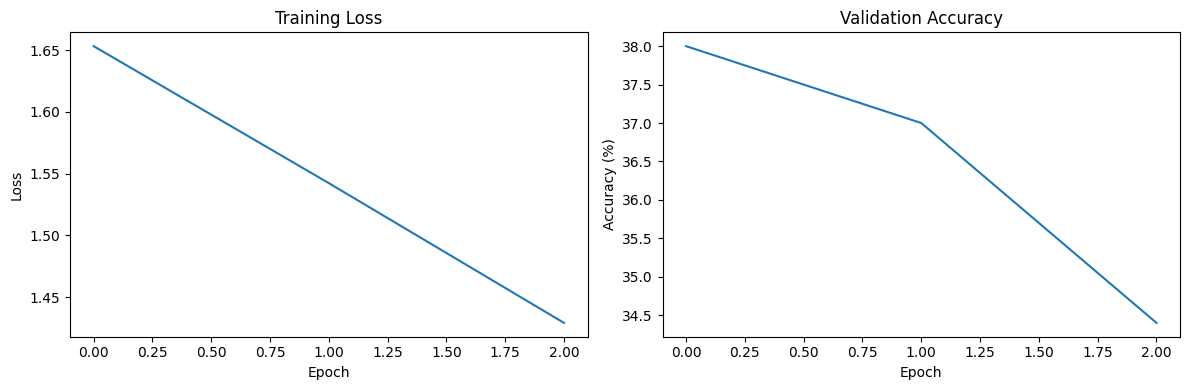

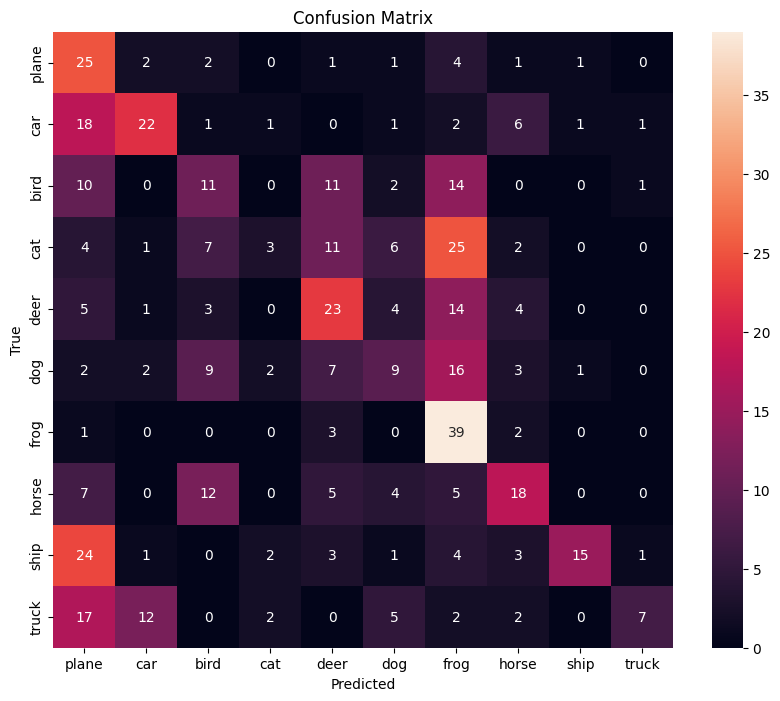


Classification Report:
              precision    recall  f1-score   support

       plane       0.22      0.68      0.33        37
         car       0.54      0.42      0.47        53
        bird       0.24      0.22      0.23        49
         cat       0.30      0.05      0.09        59
        deer       0.36      0.43      0.39        54
         dog       0.27      0.18      0.21        51
        frog       0.31      0.87      0.46        45
       horse       0.44      0.35      0.39        51
        ship       0.83      0.28      0.42        54
       truck       0.70      0.15      0.25        47

    accuracy                           0.34       500
   macro avg       0.42      0.36      0.32       500
weighted avg       0.43      0.34      0.32       500



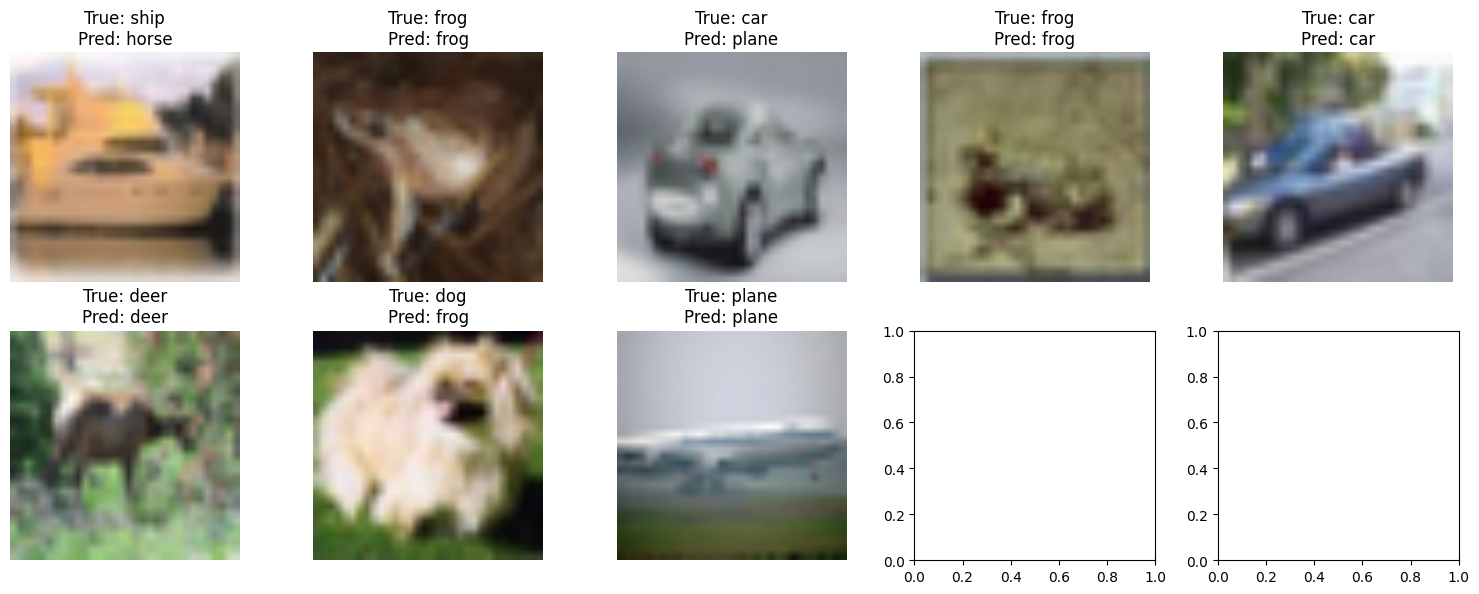

In [9]:
# Initialize optimizer and criterion
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=0.05)

# Training metrics
training_losses = []
validation_accuracies = []

def train_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    
    for batch_idx, (images, labels) in enumerate(dataloader):
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        
        if batch_idx % 100 == 0:
            print(f'Batch: {batch_idx}, Loss: {loss.item():.4f}, '
                  f'Acc: {100.*correct/total:.2f}%')
    
    return total_loss / len(dataloader), 100. * correct / total

def evaluate(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            total_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    
    return total_loss / len(dataloader), 100. * correct / total

def plot_training_history():
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(training_losses)
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    
    plt.subplot(1, 2, 2)
    plt.plot(validation_accuracies)
    plt.title('Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    
    plt.tight_layout()
    plt.show()

# Training loop
num_epochs = 3
best_acc = 0

for epoch in range(num_epochs):
    print(f'\nEpoch {epoch+1}/{num_epochs}')
    print('-' * 10)
    
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = evaluate(model, test_loader, criterion, device)
    
    training_losses.append(train_loss)
    validation_accuracies.append(val_acc)
    
    print(f'Training Loss: {train_loss:.4f}, Training Acc: {train_acc:.2f}%')
    print(f'Validation Loss: {val_loss:.4f}, Validation Acc: {val_acc:.2f}%')
    
    if val_acc > best_acc:
        best_acc = val_acc
        # Uncomment to save the best model
        # torch.save(model.state_dict(), 'best_vit_model.pth')

# Plot training history
plot_training_history()

# Evaluate on test set and create confusion matrix
def plot_confusion_matrix():
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.numpy())
    
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=classes, yticklabels=classes)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
    
    print('\nClassification Report:')
    print(classification_report(all_labels, all_preds, target_names=classes))

# Plot confusion matrix and classification report
plot_confusion_matrix()

# Visualize some predictions
def visualize_predictions():
    model.eval()
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    axes = axes.ravel()
    
    with torch.no_grad():
        for idx, (image, label) in enumerate(test_loader):
            if idx >= 10:  # Show first 10 images
                break
                
            image = image[0].to(device)
            output = model(image.unsqueeze(0))
            _, predicted = output.max(1)
            
            # Denormalize image for visualization
            img = image.cpu().numpy().transpose(1, 2, 0)
            img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
            img = np.clip(img, 0, 1)
            
            axes[idx].imshow(img)
            axes[idx].set_title(f'True: {classes[label[0]]}\nPred: {classes[predicted.item()]}')
            axes[idx].axis('off')
    
    plt.tight_layout()
    plt.show()

# Visualize some predictions
visualize_predictions()